In [87]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

dataOld = pd.read_csv("bigfu.csv", sep =';')
dataOld = dataOld.drop(['BenutzerNr', 'FahrzeugNr', 'Strecke', 'KraftstoffNr',  \
                  'Kraftstoff', 'Notiz', 'Verbrauch', 'Sparsam', \
                  'Normal', 'Schnell', 'Winter', 'Sommer', 'Ganzjahr', \
                  'Stadt', 'Land', 'Autobahn', 'Klima', 'Anhaenger'], axis=1)
dataOld.head(10)

,ArtNr,Datum,Laufleistung,Tankmenge,Kosten
0,2,2018-05-02,161152,"20,91","25,07"
1,1,2018-04-19,160309,"39,18","45,80"
2,1,2018-04-12,159559,"37,11","43,75"
3,1,2018-04-01,158783,"25,05","29,28"
4,1,2018-03-28,158231,"45,81","52,64"
5,2,2018-03-27,157746,"20,19","24,41"
6,1,2018-03-20,156987,"20,21","22,61"
7,1,2018-03-06,156605,"34,57","38,68"
8,1,2018-03-04,155956,"26,12","29,76"
9,1,2018-02-19,155498,"38,63","42,45"


In [160]:
dataNew = pd.read_csv("bigfuNew.csv", sep = r'\t', engine='python')
data = pd.concat([dataOld, dataNew])
ordData = data.sort_values(by='Datum')
carInfo = pd.DataFrame(ordData)
carInfo['Datum'] = pd.to_datetime(carInfo.Datum)
carInfo['Tankmenge'] = pd.to_numeric(carInfo.Tankmenge.apply(lambda x: x.replace(',','.')))
carInfo['Kosten'] = pd.to_numeric(carInfo.Kosten.apply(lambda x: x.replace(',','.')))
carInfo['Price'] = (carInfo.Kosten/carInfo.Tankmenge).round(3)
# tank = pd.to_numeric(ordData.Tankmenge.apply(lambda x: x.replace(',','.')))
# kosten = pd.to_numeric(ordData.Kosten.apply(lambda x: x.replace(',','.')))
carInfo = carInfo.set_index('Datum')
d2016 = pd.datetime(2016,1,1)
d2017 = pd.datetime(2017,1,1)
d2018 = pd.datetime(2018,1,1)
d2019 = pd.datetime(2019,1,1)
carInfo.head(10)

,ArtNr,Laufleistung,Tankmenge,Kosten,Price
Datum,,,,,
2016-01-29,3,107480,40.27,38.22,0.949
2016-02-08,1,108190,37.99,36.05,0.949
2016-02-18,1,109040,42.13,39.14,0.929
2016-02-25,1,109839,43.47,40.82,0.939
2016-03-04,1,110400,27.71,27.96,1.009
2016-03-07,2,111125,10.50,10.70,1.019
2016-03-08,1,111429,41.88,40.58,0.969
2016-03-18,1,111891,23.00,22.52,0.979
2016-03-23,1,112535,32.20,32.17,0.999


In [162]:
dist = []
[dist.append(carInfo.Laufleistung[i+1] - carInfo.Laufleistung[i]) for i in range(0, len(carInfo)-1)]
dist.insert(0,0) # Erstbetankung
carInfo['Distance'] = dist

AvgConsp = sum(carInfo.Tankmenge)/sum(carInfo.Distance)*100
print("Average fuel consumption is %.2f L/100km." % AvgConsp)

# Change tires dates
SummerTires = pd.DataFrame({'year': [2016, 2017, 2018],
                            'month': [4, 3, 4],
                            'day': [1, 29, 3]})
SummerTires = pd.to_datetime(SummerTires)
WinterTires = pd.DataFrame({'year': [2016, 2017, 2018],
                            'month': [10, 11, 10],
                            'day': [12, 6, 19]})
WinterTires = pd.to_datetime(WinterTires)

Average fuel consumption is 5.04 L/100km.


In [163]:
idx = [i for i in range(0, len(carInfo)) if carInfo.ArtNr[i] == 2] # get index of the not fully fuelled records
idxp1 = [item + 1 for item in idx]
odate = carInfo[carInfo.ArtNr != 1].index # dates of not fully fueled and the first fuel
date = carInfo.Tankmenge.iloc[idxp1].index
nT = [(carInfo.Tankmenge.iloc[i] + carInfo.Tankmenge.iloc[i+1]).round(2) for i in idx]
nD = [(carInfo.Distance.iloc[i] + carInfo.Distance.iloc[i+1]) for i in idx]
Lper100temp = carInfo.drop(['ArtNr', 'Laufleistung', 'Kosten', 'Price'], axis = 1)
for i in range(0, len(date)):
    Lper100temp.at[date[i], 'Tankmenge'] = nT[i]
    Lper100temp.at[date[i], 'Distance'] = nD[i]
Lper100 = Lper100temp.drop(odate)
Lper100.is_copy = False # avoid warning
Lper100['Consumption'] = (Lper100.Tankmenge/Lper100.Distance*100).round(2)
Lper100[d2019:]

,Tankmenge,Distance,Consumption
Datum,,,
2019-01-04,28.57,537,5.32
2019-01-10,22.95,394,5.82


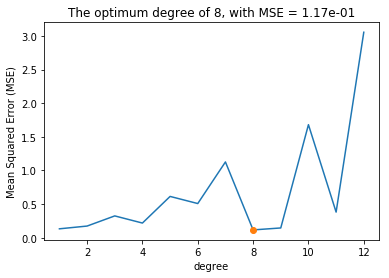

In [157]:
X = (Lper100.index - Lper100.index[0]).days.values # convert date to time interval 
X = X/1000
y = Lper100.iloc[:,2].values
degrees = list(range(1,13))
MSE = [] # mean squared error 
for val in degrees:
    # linear regression
    polynomial_features = PolynomialFeatures(degree=val, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                    ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,\
                             scoring="neg_mean_squared_error", cv=10)
    MSE.append(-scores.mean()) 
# find out the optimum degree
index_min = np.argmin(MSE)
plt.plot(degrees, MSE)
plt.plot(degrees[index_min], MSE[index_min], 'o')
plt.title("The optimum degree of {}, with MSE = {:.2e}"\
          .format(degrees[index_min], MSE[index_min]))
plt.xlabel("degree")
plt.ylabel("Mean Squared Error (MSE)")

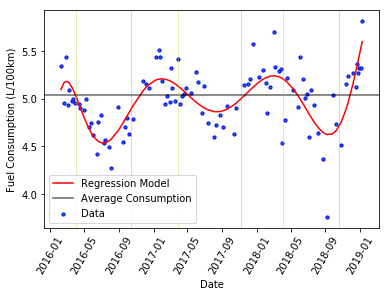

In [156]:
# linear regression
polynomial_features = PolynomialFeatures(degree=8, include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)])
pipeline.fit(X[:, np.newaxis], y)
# plot
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(Lper100.index, pipeline.predict(X[:, np.newaxis]), label="Regression Model", color = 'r')
plt.scatter(Lper100.index, y, edgecolor='b', s=10, label="Data")
plt.axhline(y = AvgConsp, color = 'k', alpha = 0.6, label = "Average Consumption")
# format
xlabel = ax.get_xticks().tolist()
ax.xaxis_date()
plt.xticks(rotation=60)
plt.legend(loc="lower left")
plt.xlabel("Date")
plt.ylabel("Fuel Consumption (L/100km)")

for i in range(len(SummerTires)):
    plt.axvline(x=SummerTires[i], linewidth = 1, color = 'y', alpha = 0.3, label = "Summer Tires")
for i in range(len(WinterTires)):
    plt.axvline(x=WinterTires[i], linewidth = 1, color = 'c', alpha = 0.3, label = "Winter Tires")